In [1]:
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr, spearmanr
from sklearn.model_selection import train_test_split
import re
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style='ticks', palette='Set2')
import sys
from tqdm.auto import tqdm
np.random.seed(42)
plt.style.use('ggplot')
import scipy.stats as stats

In [2]:
sys.path.append('../utility')
from concordance_index import concordance_index
from regression_line import abline
from repeated_analysis import repeated_analysis
from cross_validate_random_forest import cross_validate_random_forest
from string_utils import multiple_replace
from feature_selections import recursive_feature_elimination
from norm import tpm

In [3]:
!pwd

/cluster/majf_lab/mtinti/extend_UTRs/ML/decoding-gene-expression/TB


In [4]:
counts_column = ['RIBO_SRR1272136','RIBO_SRR1272137','RIBO_SRR1272138', 'RNA_SRR1272145','RNA_SRR1272146','RNA_SRR1272147','Length']

In [5]:
df = pd.read_csv('ML_DATASET.csv.gz',index_col=[0])
df['good']=[True if n.startswith('Tb927.') else False for n in df.index.values] 
df=df[df['good']]
df=df.dropna()
print(df.shape)
df.head()

(6560, 57)


,sequence_3p,sequence_5p,cds_seq,utr_3_count_A,utr_3_count_T,utr_3_count_C,utr_3_count_G,utr_3_count_AT,utr_3_count_CG,utr_3_count_CT,...,third_base_C,non_optimal_codon,RIBO_SRR1272136,RIBO_SRR1272137,RIBO_SRR1272138,RNA_SRR1272145,RNA_SRR1272146,RNA_SRR1272147,Length,good
Tb927.3.5260,TGAACAGTTGTGAAGTTAGGACGGGGCGTATGTTGCCTTCCTTTTG...,CTTCCTTTCTTTCTTTTTTCCCCCACCGCTTACTCTTTATCTATAC...,ATGTTAAGTTTTTTGATTGACTGCAGCGAAGACAAAACTGATCTCA...,0.173913,0.451691,0.200483,0.173913,0.625604,0.374396,0.652174,...,0.061702,0.355319,416,144,84,1131,139,737,1410,True
Tb927.3.5270,AGTGGGCTAACAAACACGGTAGTCGCAACGATAATAACATCGAGCT...,GCCACACGGGGGCGAGCCGATTTGGGTGGTATTTTTTCCTCCCTTC...,ATGAGTAGTGAGAGATATGTGGATGGTGACCTCGGTGAGCCTTTTA...,0.205882,0.379412,0.200000,0.214706,0.585294,0.414706,0.579412,...,0.053170,0.306748,293,162,70,1018,156,373,489,True
Tb927.3.5280,TTGGTGTGGGAGAGAATGATTCTAAATGACAAGGGCTGATCATGTG...,AGTGTGCTCTGTTGACACTGTTGGTGTAATTAATCTATTTCAAATA...,ATGACCACGTTCAAGCGGGAAGACCTCCGTCGTGTCTTTTTTAGTG...,0.192802,0.406170,0.177378,0.223650,0.598972,0.401028,0.583548,...,0.087516,0.297297,640,245,155,1748,259,756,777,True
Tb927.3.5290,ATGCGTTGAAGAAGGAGAAGCGAATTTTAAGTTTCATGAGTGTGGT...,GTGCTGAATAAGCAGCCGTGTCCACAAAACGAGAAGGAGGCCGGTG...,ATGGGTCGGGCAACAGAGGCACAACGTGCCGAAATGGCAAAGGAGG...,0.190476,0.359307,0.229437,0.220779,0.549784,0.450216,0.588745,...,0.061376,0.307937,494,219,101,1317,218,1320,2835,True
Tb927.3.5300,TGCTATTGGTAGCATTTTCGTTGTTTCATTTCGTAACCTCCTTGAG...,AAAGGATAGCACAGGTCCTCCCCCCTTTTTTCTTGGGCAGTACTCT...,ATGTTATTCACCCGCTGTCTGCTAGCGGTCACGACAATCAACAGTA...,0.181132,0.362264,0.264151,0.192453,0.543396,0.456604,0.626415,...,0.075145,0.358382,463,178,149,449,81,426,519,True


In [6]:
#targets.min()

In [7]:
#rpkm_df['TE']=rpkm_df['ribo_counts']/(rpkm_df['ribo_counts']+rpkm_df['rna_counts'])
targets = tpm(df[counts_column], df['Length'])
targets['TE']=targets[['RIBO_SRR1272136','RIBO_SRR1272137','RIBO_SRR1272138']].mean(axis=1)/(
    targets[['RIBO_SRR1272136','RIBO_SRR1272137','RIBO_SRR1272138']].mean(axis=1)+targets[['RNA_SRR1272145','RNA_SRR1272146','RNA_SRR1272147']].mean(axis=1))
targets['mean_ribo']=targets[['RIBO_SRR1272136','RIBO_SRR1272137','RIBO_SRR1272138']].mean(axis=1)
targets['mean_rna']=targets[['RNA_SRR1272145','RNA_SRR1272146','RNA_SRR1272147']].mean(axis=1)

In [8]:
df[['TE','mean_ribo','mean_rna']]=targets[['TE','mean_ribo','mean_rna']]

In [9]:
df = df.drop(['RIBO_SRR1272136','RIBO_SRR1272137','RIBO_SRR1272138']+['RNA_SRR1272145','RNA_SRR1272146','RNA_SRR1272147']+['Length'],axis=1)

In [10]:
df['utr_5_ATG']=[n.count('ATG') for n in df['sequence_5p']]
df['CDS_seq_len']=[np.log10(len(n)) for n in df['cds_seq']]

In [11]:
df['log_mean_ribo']=np.log10(df['mean_ribo'])
df['log_mean_rna']=np.log10(df['mean_rna'])

In [12]:
del df['mean_ribo']
del df['mean_rna']

In [13]:
df.columns

Index(['sequence_3p', 'sequence_5p', 'cds_seq', 'utr_3_count_A',
       'utr_3_count_T', 'utr_3_count_C', 'utr_3_count_G', 'utr_3_count_AT',
       'utr_3_count_CG', 'utr_3_count_CT', 'utr_3_count_AG',
       'utr_3_count_tracts_A_mismatch_2', 'utr_3_count_tracts_C_mismatch_2',
       'utr_3_count_tracts_CT_mismatch_2', 'utr_3_count_tracts_AG_mismatch_2',
       'utr_3_count_tracts_A_mismatch_1', 'utr_3_count_tracts_C_mismatch_1',
       'utr_3_count_tracts_CT_mismatch_1', 'utr_3_count_tracts_AG_mismatch_1',
       'utr_3_count_tracts_A_mismatch_0', 'utr_3_count_tracts_C_mismatch_0',
       'utr_3_count_tracts_CT_mismatch_0', 'utr_3_count_tracts_AG_mismatch_0',
       'utr_3_seq_len', 'utr_5_count_A', 'utr_5_count_T', 'utr_5_count_C',
       'utr_5_count_G', 'utr_5_count_AT', 'utr_5_count_CG', 'utr_5_count_CT',
       'utr_5_count_AG', 'utr_5_count_tracts_A_mismatch_2',
       'utr_5_count_tracts_C_mismatch_2', 'utr_5_count_tracts_CT_mismatch_2',
       'utr_5_count_tracts_AG_mismatch_

In [14]:
df[['log_mean_ribo','log_mean_rna','TE','sequence_3p']+['sequence_3p','utr_3_count_A', 'utr_3_count_T', 'utr_3_count_C', 'utr_3_count_G',
      'third_base_A', 'third_base_T', 'third_base_G', 'third_base_C']].to_csv('viz_dataset.csv.gz')

In [15]:
#df['utr_3_seq_len']=df['sequence_3p'].str.len()

In [16]:
to_drop = ['TE', 'sequence_3p', 'sequence_5p', 'cds_seq', 'log_mean_ribo', 'log_mean_rna', 'good']
print(len(to_drop))
to_drop = [n for n in to_drop if n in list(df.columns)]
print(len(to_drop))
#to_drop+= [n for n in df.columns if n.startswith('utr_5_')]
#'Geneid'

7
7


In [17]:
print(df.shape)
df=df.replace(-np.inf,np.nan)
df=df.replace(np.inf,np.nan)
df=df.dropna()
df.shape

(6560, 55)


(6560, 55)

In [18]:
#cor_matrix = df.drop(to_drop, axis=1).corr().abs()
#upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
#corr_to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
#print(corr_to_drop)

In [19]:
#df[df.sequence_3p.str.len()>300]

In [20]:
#df.sequence_5p.str.len().min()

In [21]:
#len(to_drop)

In [22]:
_, corr_to_drop = recursive_feature_elimination(df.drop(to_drop, axis=1), threshold=0.95)
len(corr_to_drop)

Dropping utr_5_count_CG (max correlation: 1.000)
Dropping utr_5_count_AG (max correlation: 1.000)
Dropping utr_3_count_AG (max correlation: 1.000)
Dropping utr_3_count_CG (max correlation: 1.000)
Dropping utr_5_count_tracts_C_mismatch_1 (max correlation: 0.999)
Dropping utr_3_count_tracts_C_mismatch_1 (max correlation: 0.999)
Dropping utr_3_count_tracts_A_mismatch_1 (max correlation: 0.997)
Dropping utr_5_count_tracts_A_mismatch_1 (max correlation: 0.994)
Dropping utr_5_count_tracts_C_mismatch_0 (max correlation: 0.994)
Dropping utr_3_count_tracts_C_mismatch_0 (max correlation: 0.992)
Dropping utr_3_count_tracts_AG_mismatch_1 (max correlation: 0.990)
Dropping utr_3_count_tracts_CT_mismatch_1 (max correlation: 0.986)
Dropping utr_5_count_tracts_AG_mismatch_1 (max correlation: 0.985)
Dropping utr_5_count_tracts_CT_mismatch_1 (max correlation: 0.984)
Dropping utr_5_count_tracts_A_mismatch_0 (max correlation: 0.969)
Dropping utr_3_count_tracts_A_mismatch_0 (max correlation: 0.968)


16

In [23]:
X=df.drop(to_drop, axis=1).drop(corr_to_drop, axis=1)
y=df['log_mean_rna']

In [24]:
results = cross_validate_random_forest(X, y, n_splits=3)

all_predictions = results['predictions']
all_true_values = results['true_values']
regr = results['model']
fold_metrics = results['fold_metrics']
X_train, y_train = results['train_data']
X_test, y_test = results['test_data']

Fold 1 - R2: 0.4651, RMSE: 0.2840
Fold 2 - R2: 0.4758, RMSE: 0.2814
Fold 3 - R2: 0.4785, RMSE: 0.2848

Overall Metrics:
Mean R2: 0.4731 ± 0.0071
Mean RMSE: 0.2834 ± 0.0018


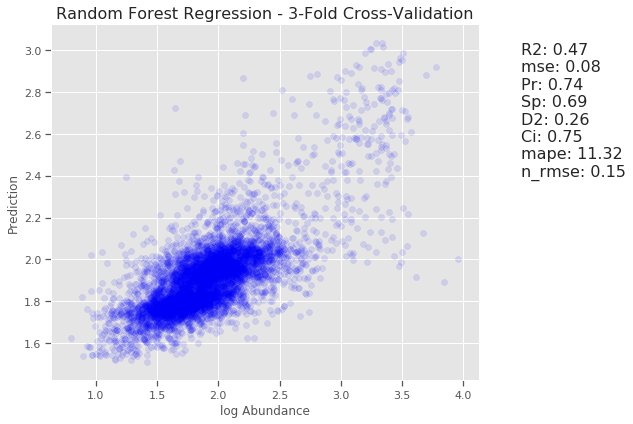

In [25]:
# Plotting
fig, ax = plt.subplots(figsize=(9, 6))
ax.scatter(all_true_values, all_predictions, c='blue', alpha=0.1)
abline(all_true_values, all_predictions, ax, text_loc = [1.1, 0.95])
ax.set_ylabel('Prediction')
ax.set_xlabel('log Abundance')
ax.set_title('Random Forest Regression - 3-Fold Cross-Validation',fontsize=16)
plt.tight_layout()
plt.show()

In [26]:
oof_df = pd.DataFrame()
oof_df['oof_mRNAabundance']=all_predictions

In [27]:

    
feature_names = [multiple_replace(n) for n in list(X_test.columns)]

In [28]:
#shap.summary_plot??

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


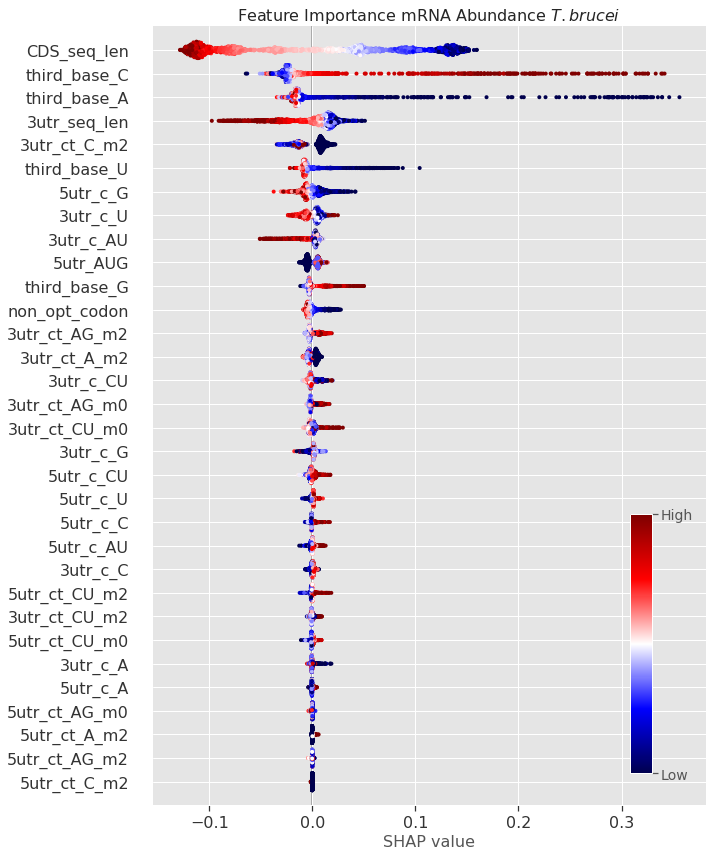

In [29]:
import shap
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib

# Now we use the SHAP scoring system to visualise 
# the most important features for the model
explainer = shap.TreeExplainer(regr)
shap_values = explainer.shap_values(X_test)

# Create the SHAP summary plot
shap.summary_plot(shap_values, 
                  X_test, 
                  feature_names=feature_names,
                  max_display=50, show=False, color_bar=False)

# Get the current figure and axes
f = plt.gcf()
f.set_size_inches(10, 12)
ax = plt.gca()

# Customize the plot
plt.title('Feature Importance mRNA Abundance $\it{T. brucei}$', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('SHAP value', fontsize=16)

my_cmap = plt.get_cmap('seismic')

# Change the colormap of the artists
for child in ax.get_children():
    if hasattr(child, "set_cmap"):
        child.set_cmap(my_cmap)

# Create the colorbar and adjust its size
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
cbar_ax = f.add_axes([0.88, 0.1, 0.03, 0.3])
cbar = f.colorbar(cm.ScalarMappable(norm=norm, cmap='seismic'), cax=cbar_ax, shrink=0.5)
cbar.set_ticks([-1, 1])
cbar.set_ticklabels(['Low', 'High'])
cbar.ax.tick_params(labelsize=14)

plt.tight_layout()
plt.savefig('UTR_seismic_TB_MRNA_abundance.png')
plt.savefig('UTR_seismic_TB_MRNA_abundance.svg')

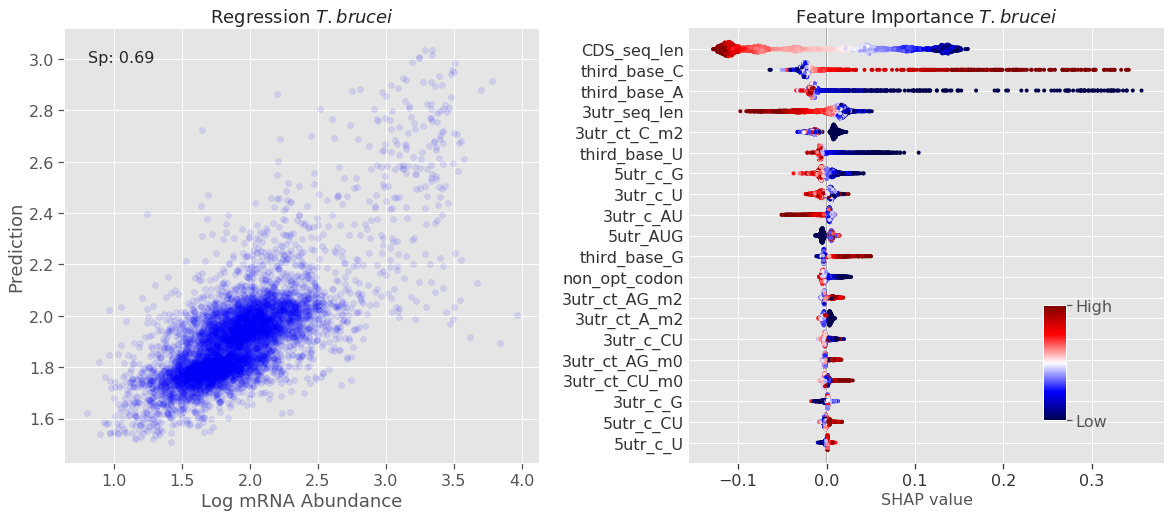

In [30]:
import matplotlib
fig = plt.figure(figsize=(16, 8))
# Increase right margin to accommodate colorbar
plt.subplots_adjust(left=0.1, right=0.85)  # Adjusted right margin

# Create gridspec without the colorbar position
gs = fig.add_gridspec(1, 2, width_ratios=[0.45, 0.45], wspace=0.4)
axes = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1])]
plt.rcParams.update({'font.size': 16})

# First plot (scatter plot)
axes[0].scatter(all_true_values, all_predictions,  c='blue', alpha=0.1)
abline(all_true_values, all_predictions, axes[0], visualize = ['Sp'])
axes[0].set_ylabel('Prediction', fontsize=18)
axes[0].set_xlabel('Log mRNA Abundance', fontsize=18)
#axes[0].set_title('Regression T. brucei', fontsize=18)
axes[0].set_title('Regression $\it{T. brucei}$', fontsize=18)
axes[0].tick_params(axis='both', labelsize=16)

# Simple seismic colorbar first
my_cmap = plt.get_cmap('seismic')
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)

# SHAP plot in the middle
plt.sca(axes[1])  
shap.summary_plot(shap_values, 
                 X_test, 
                 feature_names=feature_names,
                 max_display=20, show=False, plot_size=(16,8), color_bar=False)
axes[1].tick_params(axis='both', labelsize=16)  
axes[1].set_title('Feature Importance $\it{T. brucei}$', fontsize=18)
axes[1].set_xlabel('SHAP value', fontsize=16)

# Apply colormap
for fc in fig.get_children():
    for fcc in fc.get_children():
        if hasattr(fcc, "set_cmap"): 
            fcc.set_cmap(my_cmap)

# Adjust positions manually for main plots
pos0 = axes[0].get_position()
pos1 = axes[1].get_position()
axes[0].set_position([pos0.x0, pos0.y0, pos0.width+0.1, pos0.height])
axes[1].set_position([pos1.x0+0.105, pos1.y0, pos1.width+0.1, pos1.height])
axes[1].tick_params(axis='y', pad=-15)
# Add colorbar after adjusting main plots
cax = fig.add_axes([0.95, 0.2, 0.02, 0.2])  # [left, bottom, width, height]
cb = matplotlib.colorbar.ColorbarBase(cax, cmap=my_cmap, norm=norm)
cb.set_ticks([-1, 1])
cb.set_ticklabels(['Low', 'High'])
cb.ax.tick_params(labelsize=16)

plt.savefig('Tb_mRNA_Abundance.png', bbox_inches='tight', dpi=300)
plt.savefig('Tb_mRNA_Abundance.svg', bbox_inches='tight')
plt.show()

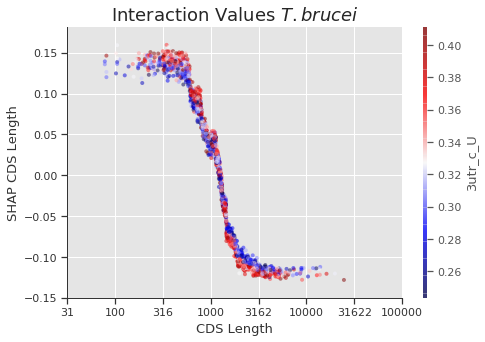

In [31]:
shap.dependence_plot('CDS_seq_len', 
                     shap_values, 
                     X_test,show=False,
                     cmap='seismic',feature_names=feature_names, alpha=0.5)
plt.title('Interaction Values $\it{T. brucei}$',fontsize=18)
plt.ylabel('SHAP CDS Length')
plt.xlabel('CDS Length')
current_ticks = plt.xticks()[0]
new_labels = [str(int(10**x)) for x in current_ticks]
plt.xticks(current_ticks, new_labels)
new_labels[-1]=''
new_labels[0]=''
plt.show()

In [32]:
#pd.concat([results_df.mean(),results_df.std()],axis=1)

In [33]:
X.columns

Index(['utr_3_count_A', 'utr_3_count_T', 'utr_3_count_C', 'utr_3_count_G',
       'utr_3_count_AT', 'utr_3_count_CT', 'utr_3_count_tracts_A_mismatch_2',
       'utr_3_count_tracts_C_mismatch_2', 'utr_3_count_tracts_CT_mismatch_2',
       'utr_3_count_tracts_AG_mismatch_2', 'utr_3_count_tracts_CT_mismatch_0',
       'utr_3_count_tracts_AG_mismatch_0', 'utr_3_seq_len', 'utr_5_count_A',
       'utr_5_count_T', 'utr_5_count_C', 'utr_5_count_G', 'utr_5_count_AT',
       'utr_5_count_CT', 'utr_5_count_tracts_A_mismatch_2',
       'utr_5_count_tracts_C_mismatch_2', 'utr_5_count_tracts_CT_mismatch_2',
       'utr_5_count_tracts_AG_mismatch_2', 'utr_5_count_tracts_CT_mismatch_0',
       'utr_5_count_tracts_AG_mismatch_0', 'third_base_A', 'third_base_T',
       'third_base_G', 'third_base_C', 'non_optimal_codon', 'utr_5_ATG',
       'CDS_seq_len'],
      dtype='object')

In [34]:
results_df = repeated_analysis(X, y)
results_df['analysis_sp']='TB'
results_df['analysis_type']='Abundance_All'
results_df.to_csv('stats_TB_Abundance_All.csv')

print("Average Sp: {:.4f} ± {:.4f}".format(
    results_df['Sp'].mean(), results_df['Sp'].std()))

only_utr = [n for n in list(X.columns) if n.startswith('utr_')]
only_codon = [n for n in list(X.columns) if not n.startswith('utr_')]
results_df = repeated_analysis(X[only_utr], y)
results_df['analysis_sp']='TB'
results_df['analysis_type']='Abundance_utr'
results_df.to_csv('stats_TB_Abundance_utr.csv')

print("Average Sp: {:.4f} ± {:.4f}".format(
    results_df['Sp'].mean(), results_df['Sp'].std()))

results_df = repeated_analysis(X[only_codon], y)
results_df['analysis_sp']='TB'
results_df['analysis_type']='Abundance_codon'
results_df.to_csv('stats_TB_Abundance_codon.csv')

print("Average Sp: {:.4f} ± {:.4f}".format(
    results_df['Sp'].mean(), results_df['Sp'].std()))


  0%|          | 0/100 [00:00<?, ?it/s]

Average Sp: 0.6668 ± 0.0138


  0%|          | 0/100 [00:00<?, ?it/s]

Average Sp: 0.3334 ± 0.0173


100%|██████████| 100/100 [01:05<00:00,  1.52it/s]

Average Sp: 0.6498 ± 0.0118


In [35]:
#X.columns

In [36]:
X=df.drop(to_drop, axis=1).drop(corr_to_drop, axis=1)
y=df['TE']

Fold 1 - R2: 0.3776, RMSE: 0.1370
Fold 2 - R2: 0.3632, RMSE: 0.1408
Fold 3 - R2: 0.3813, RMSE: 0.1353

Overall Metrics:
Mean R2: 0.3740 ± 0.0096
Mean RMSE: 0.1377 ± 0.0028


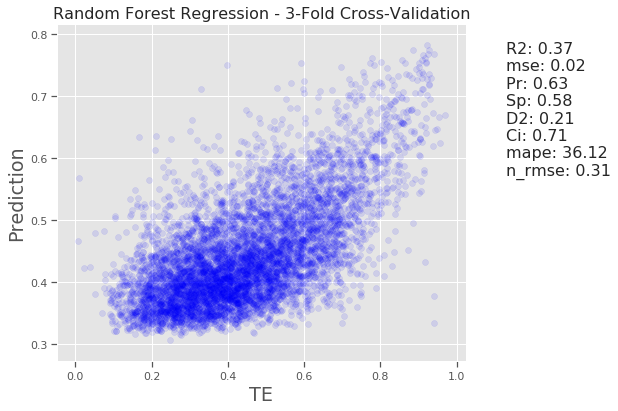

In [37]:
# Assuming X is a pandas DataFrame and y is a pandas Series
#all_predictions, all_true_values, regr, X_train, X_test, y_train, y_test = cross_validate_random_forest(X, y)
results = cross_validate_random_forest(X, y, n_splits=3)

# Access components from results dictionary
all_predictions = results['predictions']
all_true_values = results['true_values']
regr = results['model']
fold_metrics = results['fold_metrics']
X_train, y_train = results['train_data']
X_test, y_test = results['test_data']



# Plotting
fig, ax = plt.subplots(figsize=(9, 6))
ax.scatter(all_true_values, all_predictions , c='blue', alpha=0.1)
abline(all_true_values, all_predictions, ax, text_loc = [1.1, 0.95])
ax.set_ylabel('Prediction')
ax.set_xlabel('TE')
ax.set_title('Random Forest Regression - 3-Fold Cross-Validation',fontsize=16)
plt.tight_layout()
plt.show()



In [38]:
oof_df['oofs_TE']=all_predictions

In [39]:
#regr

In [40]:
X_test.shape

(2186, 32)

In [41]:
#explainer = shap.TreeExplainer(regr, data=X_test)
#shap_values = explainer.shap_values(X_test, check_additivity=False)


Setting feature_perturbation = "tree_path_dependent" because no background data was given.
This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


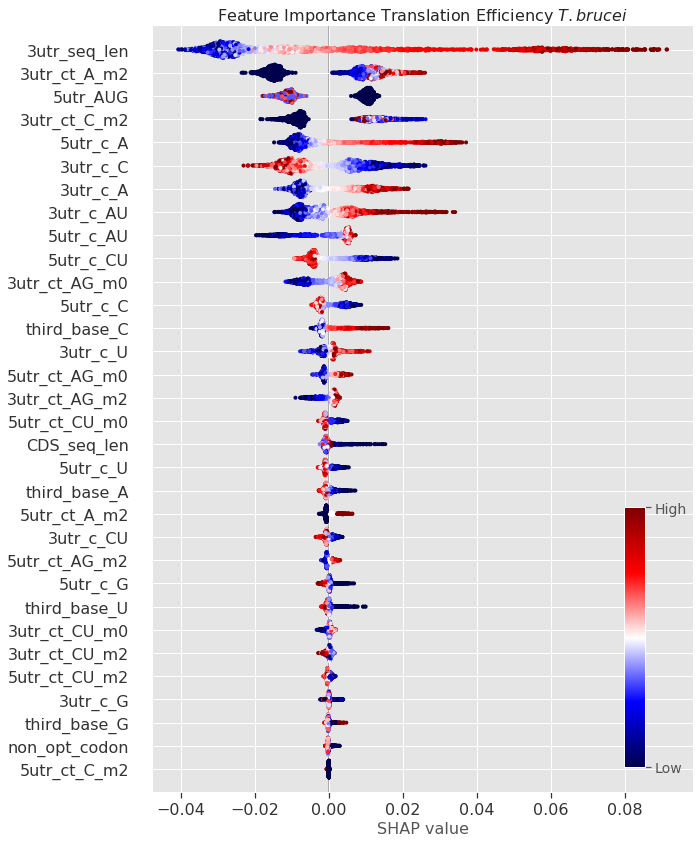

In [42]:
import shap
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib

# Now we use the SHAP scoring system to visualise 
# the most important features for the model
explainer = shap.TreeExplainer(regr)
shap_values = explainer.shap_values(X_test)

# Create the SHAP summary plot
shap.summary_plot(shap_values, 
                  X_test, 
                  feature_names=feature_names,
                  max_display=50, show=False, color_bar=False)

# Get the current figure and axes
f = plt.gcf()
f.set_size_inches(10, 12)
ax = plt.gca()

# Customize the plot
plt.title('Feature Importance Translation Efficiency $\it{T. brucei}$', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('SHAP value', fontsize=16)

my_cmap = plt.get_cmap('seismic')

# Change the colormap of the artists
for child in ax.get_children():
    if hasattr(child, "set_cmap"):
        child.set_cmap(my_cmap)

# Create the colorbar and adjust its size
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
cbar_ax = f.add_axes([0.88, 0.1, 0.03, 0.3])
cbar = f.colorbar(cm.ScalarMappable(norm=norm, cmap='seismic'), cax=cbar_ax, shrink=0.5)
cbar.set_ticks([-1, 1])
cbar.set_ticklabels(['Low', 'High'])
cbar.ax.tick_params(labelsize=14)

plt.tight_layout()
plt.savefig('UTR_seismic_TB_TE.png')
plt.savefig('UTR_seismic_TB_TE.svg')

In [43]:
feature_names = [multiple_replace(n) for n in list(X_test.columns)]

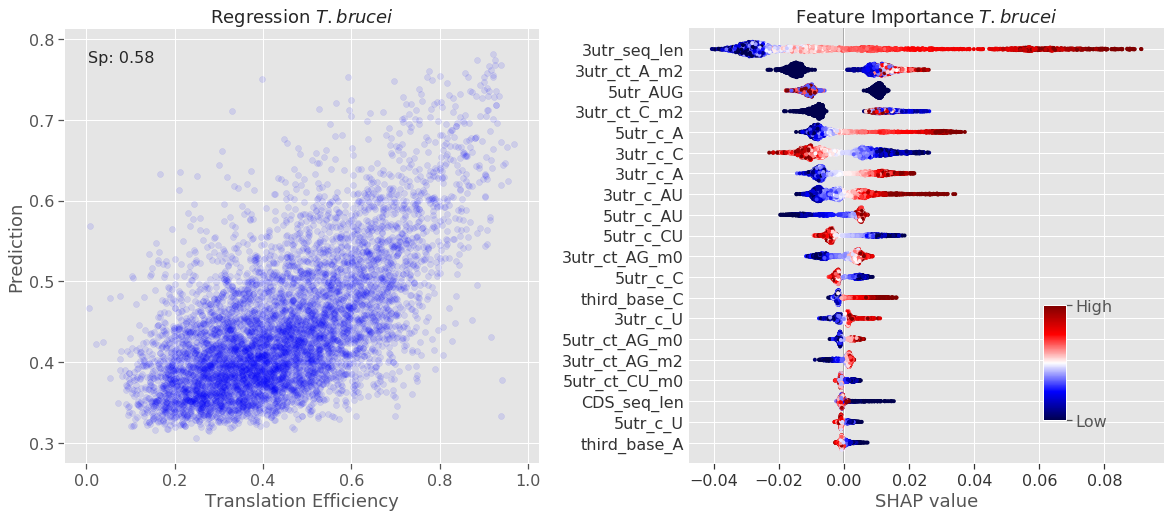

In [44]:
import matplotlib
fig = plt.figure(figsize=(16, 8))
# Increase right margin to accommodate colorbar
plt.subplots_adjust(left=0.1, right=0.85)  # Adjusted right margin

# Create gridspec without the colorbar position
gs = fig.add_gridspec(1, 2, width_ratios=[0.45, 0.45], wspace=0.4)
axes = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1])]
plt.rcParams.update({'font.size': 16})

# First plot (scatter plot)
axes[0].scatter(all_true_values, all_predictions, c='blue', alpha=0.1)
abline(all_true_values, all_predictions, axes[0], visualize = ['Sp'])
axes[0].set_ylabel('Prediction', fontsize=18)
axes[0].set_xlabel('Translation Efficiency', fontsize=18)
axes[0].set_title('Regression $\it{T. brucei}$', fontsize=18)
axes[0].tick_params(axis='both', labelsize=16)

# Simple seismic colorbar first
my_cmap = plt.get_cmap('seismic')
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)

# SHAP plot in the middle
plt.sca(axes[1])  
shap.summary_plot(shap_values, 
                 X_test, 
                 feature_names=feature_names,
                 max_display=20, show=False, plot_size=(16,8), color_bar=False)
axes[1].tick_params(axis='both', labelsize=16)  
axes[1].set_title('Feature Importance $\it{T. brucei}$', fontsize=18)
axes[1].set_xlabel('SHAP value', fontsize=18)

# Apply colormap
for fc in fig.get_children():
    for fcc in fc.get_children():
        if hasattr(fcc, "set_cmap"): 
            fcc.set_cmap(my_cmap)

# Adjust positions manually for main plots
pos0 = axes[0].get_position()
pos1 = axes[1].get_position()
axes[0].set_position([pos0.x0, pos0.y0, pos0.width+0.1, pos0.height])
axes[1].set_position([pos1.x0+0.105, pos1.y0, pos1.width+0.1, pos1.height])
axes[1].tick_params(axis='y', pad=-15)
# Add colorbar after adjusting main plots
cax = fig.add_axes([0.95, 0.2, 0.02, 0.2])  # [left, bottom, width, height]
cb = matplotlib.colorbar.ColorbarBase(cax, cmap=my_cmap, norm=norm)
cb.set_ticks([-1, 1])
cb.set_ticklabels(['Low', 'High'])
cb.ax.tick_params(labelsize=16)

plt.savefig('Tb_TE.png', bbox_inches='tight', dpi=300)
plt.savefig('Tb_TE.svg', bbox_inches='tight')
plt.show()

In [48]:
#X_test['utr_3_count_tracts_A_mismatch_2'].describe()

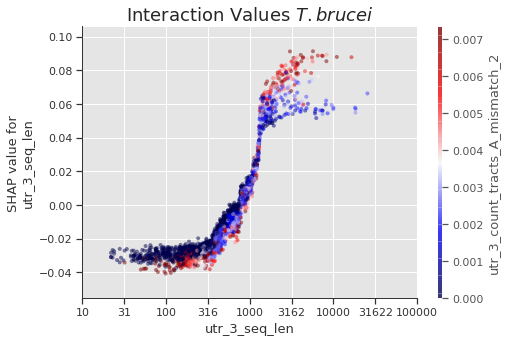

In [49]:
shap.dependence_plot('utr_3_seq_len', 
                     shap_values, 
                     X_test,show=False,
                     cmap='seismic',alpha=0.5,
                    interaction_index='utr_3_count_tracts_A_mismatch_2')
plt.title('Interaction Values $\it{T. brucei}$',fontsize=18)
#plt.ylabel('SHAP 3UTR Length')
#plt.xlabel('3UTR Length')
current_ticks = plt.xticks()[0]
new_labels = [str(int(10**x)) for x in current_ticks]
plt.xticks(current_ticks, new_labels)
new_labels[-1]=''
new_labels[0]=''
#plt.ylim(-0.1,0.15)
plt.show()

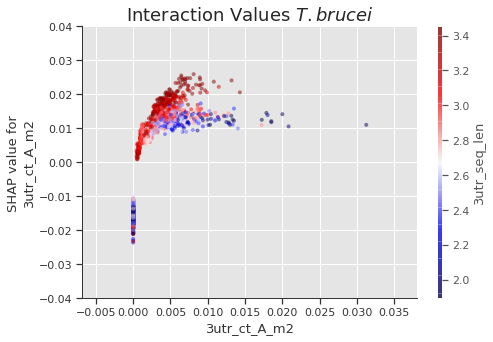

In [50]:
shap.dependence_plot('3utr_ct_A_m2', 
                     shap_values, 
                     X_test,show=False,
                     cmap='seismic',feature_names=feature_names, alpha=0.5)
plt.title('Interaction Values $\it{T. brucei}$',fontsize=18)
#plt.ylabel('SHAP 3UTR Length')
#plt.xlabel('3UTR Length')
current_ticks = plt.xticks()[0]
new_labels = [str(int(100*x)) for x in current_ticks]
#plt.xticks(current_ticks, new_labels)
new_labels[-1]=''
new_labels[0]=''
plt.ylim(-0.04,0.04)
plt.show()

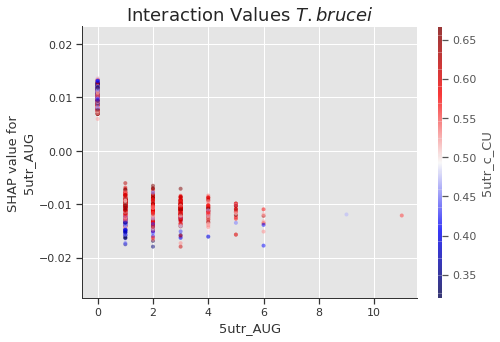

In [51]:
shap.dependence_plot('5utr_AUG', 
                     shap_values, 
                     X_test,show=False,
                     cmap='seismic',feature_names=feature_names, alpha=0.5)
plt.title('Interaction Values $\it{T. brucei}$',fontsize=18)
#plt.ylabel('SHAP 3UTR Length')
#plt.xlabel('3UTR Length')
#current_ticks = plt.xticks()[0]
#new_labels = [str(int(10**x)) for x in current_ticks]
#plt.xticks(current_ticks, new_labels)
#new_labels[-1]=''
#new_labels[0]=''
plt.show()

In [52]:
results_df = repeated_analysis(X, y)
results_df['analysis_sp']='TB'
results_df['analysis_type']='TE_All'
results_df.to_csv('stats_TB_TE_All.csv')

print("Average Sp: {:.4f} ± {:.4f}".format(
    results_df['Sp'].mean(), results_df['Sp'].std()))

only_utr = [n for n in list(X.columns) if n.startswith('utr_')]
only_codon = [n for n in list(X.columns) if not n.startswith('utr_')]
results_df = repeated_analysis(X[only_utr], y)
results_df['analysis_sp']='TB'
results_df['analysis_type']='TE_utr'
results_df.to_csv('stats_TB_TE_utr.csv')

print("Average Sp: {:.4f} ± {:.4f}".format(
    results_df['Sp'].mean(), results_df['Sp'].std()))

results_df = repeated_analysis(X[only_codon], y)
results_df['analysis_sp']='TB'
results_df['analysis_type']='TE_codon'
results_df.to_csv('stats_TB_TE_codon.csv')

print("Average Sp: {:.4f} ± {:.4f}".format(
    results_df['Sp'].mean(), results_df['Sp'].std()))



  0%|          | 0/100 [00:00<?, ?it/s]

Average Sp: 0.5682 ± 0.0153


  0%|          | 0/100 [00:00<?, ?it/s]

Average Sp: 0.5648 ± 0.0145


100%|██████████| 100/100 [01:05<00:00,  1.52it/s]

Average Sp: 0.2132 ± 0.0208


In [53]:
#protein_data = pd.read_csv('../../TB/927 iBAQ.csv',index_col=['Gene_id'])
#protein_data.to_csv('iBAQ_927.csv.gz')

In [54]:
protein_data = pd.read_csv('iBAQ_927.csv.gz',index_col=[0])
protein_data['iBAQ_BSF']=protein_data['bsf']
protein_data.head()

,Gene_acc,bsf,pcf,rank_bsf,rank_pcf,Desc,prot_group,iBAQ_BSF
Gene_id,,,,,,,,
Tb427.BES40.1,aa0aa,3.29,6.92,302.0,5941.0,Tb427.BES40.1,PG0,3.29
Tb927.10.10190,aa1000aa,3.18,3.66,14.0,1188.0,Leucine-rich repeat domain containing protein,PG569,3.18
Tb927.10.10200,aa1001aa,5.04,3.61,1733.0,817.0,"hypothetical protein, conserved",PG570,5.04
Tb927.10.10280,aa1002aa,5.87,5.77,3525.0,3939.0,Microtubule-associated repetitive protein 2,PG571,5.87
Tb927.10.10320,aa1003aa,7.04,6.63,5806.0,5598.0,"dynein light chain Tctex-type, putative",PG572,7.04


In [55]:
protein_data = df.join(protein_data[['iBAQ_BSF','prot_group']],how='left').drop_duplicates('prot_group',keep='first').dropna()
del protein_data['prot_group']
protein_data.head()

,sequence_3p,sequence_5p,cds_seq,utr_3_count_A,utr_3_count_T,utr_3_count_C,utr_3_count_G,utr_3_count_AT,utr_3_count_CG,utr_3_count_CT,...,third_base_G,third_base_C,non_optimal_codon,good,TE,utr_5_ATG,CDS_seq_len,log_mean_ribo,log_mean_rna,iBAQ_BSF
Tb927.1.1000,GGGAATCTTATTACTTTTGATCGATACCCGAGCACTATTTTGATGT...,ATGTTTGTGAAACTGTGTGTACTTTCCCTCTATTATCATTCACTTC...,ATGCGTCGCTTATTGTGTCTCTCACGCACTCGTGTTTCCTTCATGA...,0.179039,0.353712,0.213974,0.253275,0.532751,0.467249,0.567686,...,0.092637,0.081552,0.211401,True,0.291094,4,3.101403,1.608622,1.995177,3.36
Tb927.1.1010,TGGACCTTGGAAGGGCTAAGAGTCACATTGCTCGCACGTTTGTACT...,CGATTCGAGTTAACTCTATTCCGTCCGTTCTCGTATCCCCCTTGTC...,ATGGACGGCAGTGAGTGCTTTCTCGTGACACCGACTCGGTGGGGGC...,0.261484,0.282686,0.222615,0.233216,0.544170,0.455830,0.505300,...,0.097222,0.073148,0.250000,True,0.299672,2,3.334454,1.320887,1.689541,4.25
Tb927.1.1020,GGGTGTGGCAGGACACGTAACGTGAAGCAGCATAGAAATTGCTATA...,TATTACTTGCGTTAATATGTCGAAAGTGATCGCAAGGACGTTAGTT...,ATGGGTTGTGCAGGGAGTCAGCAGCAAAAACCTCGTAGCAATCAAA...,0.264234,0.271533,0.214599,0.249635,0.535766,0.464234,0.486131,...,0.092896,0.080406,0.309133,True,0.396334,1,3.107549,1.389900,1.572635,5.69
Tb927.1.1025,TACATAGCCCGGAGAATGTTTGGTGGCCGCCAAAGTTGTCAAATTC...,CTCGCGTTGCGCATCGCACATAGGTCTGCATTCTTTCTTTTTCCCT...,ATGTTTCGCTCGTCGATGGTAGTGCGGTCCTTTACGCAGGAATCTT...,0.229508,0.319672,0.188525,0.262295,0.549180,0.450820,0.508197,...,0.107143,0.099206,0.285714,True,0.321977,0,2.401401,1.885333,2.208752,3.33
Tb927.1.1050,TTAGGTAAAACAAAGGTCCCCATCCTGACACTTTTTTTTTGTTATA...,GCCGGTGGCTAGGACGAAAGTTGCTCGAGGAAAAGTGCTTGCTTTT...,ATGAATGTCACTAACCCCTCCACTGTCAGGTACGCCGATGCATTCA...,0.189286,0.332143,0.217857,0.260714,0.521429,0.478571,0.550000,...,0.090557,0.085493,0.245755,True,0.411291,0,3.525951,1.318689,1.474440,5.66


In [56]:
protein_data_bk = protein_data.copy()

In [57]:
#X_train.shape,X_test.shape

In [58]:
to_drop = [ 'sequence_3p', 'sequence_5p', 'cds_seq',  'good','log_mean_ribo', 'log_mean_rna','TE']#'

Fold 1 - R2: 0.2760, RMSE: 0.7740
Fold 2 - R2: 0.2870, RMSE: 0.7910
Fold 3 - R2: 0.2764, RMSE: 0.7811

Overall Metrics:
Mean R2: 0.2798 ± 0.0062
Mean RMSE: 0.7820 ± 0.0085


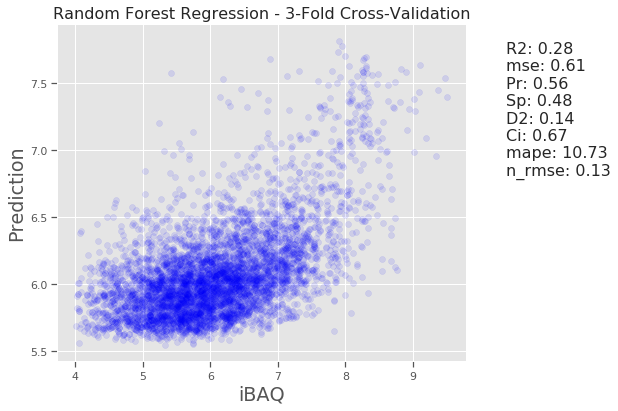

In [59]:
protein_data=protein_data[protein_data['iBAQ_BSF']>4]
X=protein_data.drop(to_drop+['iBAQ_BSF'], axis=1).drop(corr_to_drop, axis=1)
y=protein_data['iBAQ_BSF']


# Assuming X is a pandas DataFrame and y is a pandas Series
#all_predictions, all_true_values, regr, X_train, X_test, y_train, y_test = cross_validate_random_forest(X, y)
results = cross_validate_random_forest(X, y, n_splits=3)

# Access components from results dictionary
all_predictions = results['predictions']
all_true_values = results['true_values']
regr = results['model']
fold_metrics = results['fold_metrics']
X_train, y_train = results['train_data']
X_test, y_test = results['test_data']

feature_names = [multiple_replace(n) for n in list(X_test.columns)]

# Plotting
fig, ax = plt.subplots(figsize=(9, 6))
ax.scatter(all_true_values, all_predictions , c='blue', alpha=0.1)
abline(all_true_values, all_predictions, ax, text_loc = [1.1, 0.95])
ax.set_ylabel('Prediction')
ax.set_xlabel('iBAQ')
ax.set_title('Random Forest Regression - 3-Fold Cross-Validation',fontsize=16)
plt.tight_layout()
plt.show()



Setting feature_perturbation = "tree_path_dependent" because no background data was given.


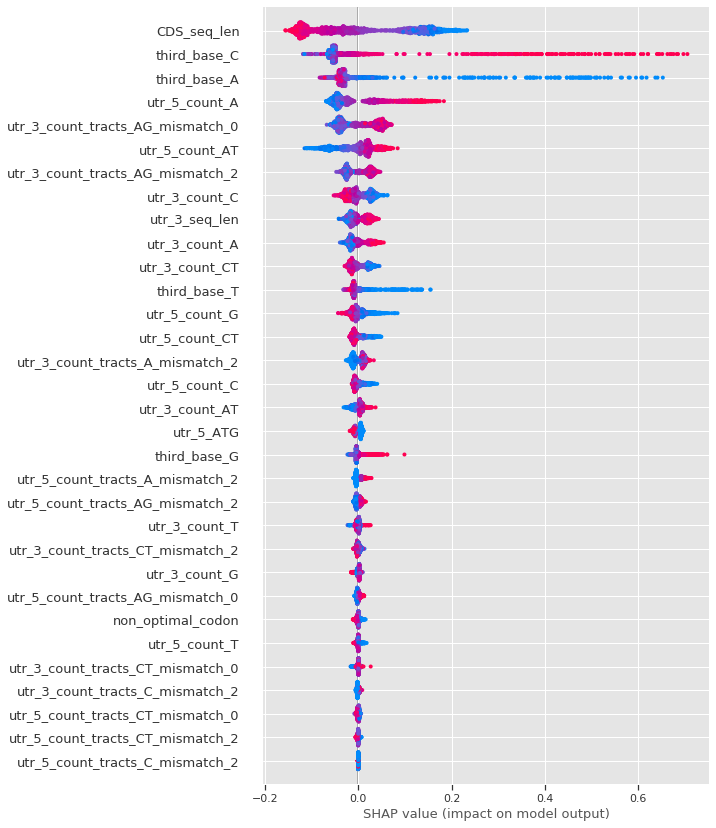

In [60]:
explainer = shap.TreeExplainer(regr)
shap_values = explainer.shap_values(X_test)

# Create the SHAP summary plot
shap.summary_plot(shap_values, 
                  X_test, 
                  feature_names=X_test.columns,
                  max_display=50, show=False, color_bar=False)

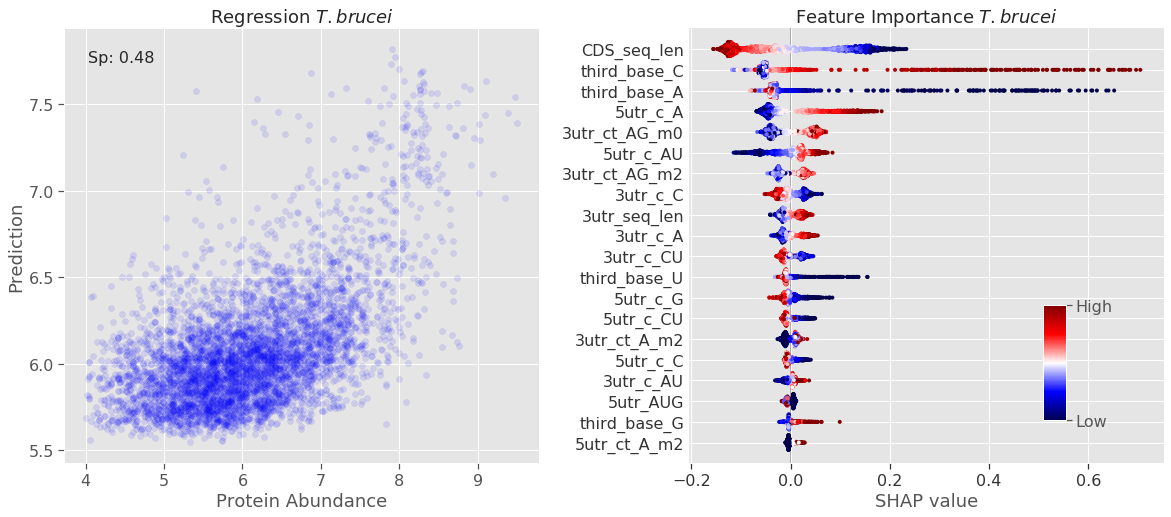

In [61]:
import matplotlib
fig = plt.figure(figsize=(16, 8))
# Increase right margin to accommodate colorbar
plt.subplots_adjust(left=0.1, right=0.85)  # Adjusted right margin

# Create gridspec without the colorbar position
gs = fig.add_gridspec(1, 2, width_ratios=[0.45, 0.45], wspace=0.4)
axes = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1])]
plt.rcParams.update({'font.size': 16})

# First plot (scatter plot)
axes[0].scatter(all_true_values, all_predictions, c='blue', alpha=0.1)
abline(all_true_values, all_predictions, axes[0], visualize = ['Sp'])
axes[0].set_ylabel('Prediction', fontsize=18)
axes[0].set_xlabel('Protein Abundance', fontsize=18)
axes[0].set_title('Regression $\it{T. brucei}$', fontsize=18)
axes[0].tick_params(axis='both', labelsize=16)

# Simple seismic colorbar first
my_cmap = plt.get_cmap('seismic')
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)

feature_names = [multiple_replace(n) for n in list(X_test.columns)]
# SHAP plot in the middle
plt.sca(axes[1])  
shap.summary_plot(shap_values, 
                 X_test, 
                 feature_names=feature_names,
                 max_display=20, show=False, plot_size=(16,8), color_bar=False)
axes[1].tick_params(axis='both', labelsize=16)  
axes[1].set_title('Feature Importance $\it{T. brucei}$', fontsize=18)
axes[1].set_xlabel('SHAP value', fontsize=18)

# Apply colormap
for fc in fig.get_children():
    for fcc in fc.get_children():
        if hasattr(fcc, "set_cmap"): 
            fcc.set_cmap(my_cmap)

# Adjust positions manually for main plots
pos0 = axes[0].get_position()
pos1 = axes[1].get_position()
axes[0].set_position([pos0.x0, pos0.y0, pos0.width+0.1, pos0.height])
axes[1].set_position([pos1.x0+0.105, pos1.y0, pos1.width+0.1, pos1.height])
axes[1].tick_params(axis='y', pad=-15)
# Add colorbar after adjusting main plots
cax = fig.add_axes([0.95, 0.2, 0.02, 0.2])  # [left, bottom, width, height]
cb = matplotlib.colorbar.ColorbarBase(cax, cmap=my_cmap, norm=norm)
cb.set_ticks([-1, 1])
cb.set_ticklabels(['Low', 'High'])
cb.ax.tick_params(labelsize=16)

#plt.savefig('Tb_TE.png', bbox_inches='tight', dpi=300)
#plt.savefig('Tb_TE.svg', bbox_inches='tight')
#plt.show()

In [62]:
protein_data = protein_data_bk.copy()
to_drop = [ 'sequence_3p', 'sequence_5p', 'cds_seq',  'good']#'log_mean_ribo', 'log_mean_rna','TE']#'

Fold 1 - R2: 0.5682, RMSE: 0.5977
Fold 2 - R2: 0.5581, RMSE: 0.6227
Fold 3 - R2: 0.5691, RMSE: 0.6027

Overall Metrics:
Mean R2: 0.5652 ± 0.0061
Mean RMSE: 0.6077 ± 0.0132


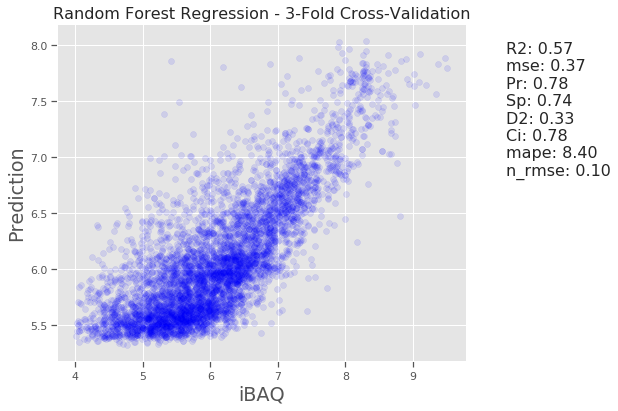

In [63]:
protein_data=protein_data[protein_data['iBAQ_BSF']>4]
X=protein_data.drop(to_drop+['iBAQ_BSF'], axis=1).drop(corr_to_drop, axis=1)
y=protein_data['iBAQ_BSF']


# Assuming X is a pandas DataFrame and y is a pandas Series
#all_predictions, all_true_values, regr, X_train, X_test, y_train, y_test = cross_validate_random_forest(X, y)
results = cross_validate_random_forest(X, y, n_splits=3)

# Access components from results dictionary
all_predictions = results['predictions']
all_true_values = results['true_values']
regr = results['model']
fold_metrics = results['fold_metrics']
X_train, y_train = results['train_data']
X_test, y_test = results['test_data']

feature_names = [multiple_replace(n) for n in list(X_test.columns)]

# Plotting
fig, ax = plt.subplots(figsize=(9, 6))
ax.scatter(all_true_values, all_predictions , c='blue', alpha=0.1)
abline(all_true_values, all_predictions, ax, text_loc = [1.1, 0.95])
ax.set_ylabel('Prediction')
ax.set_xlabel('iBAQ')
ax.set_title('Random Forest Regression - 3-Fold Cross-Validation',fontsize=16)
plt.tight_layout()
plt.show()



Setting feature_perturbation = "tree_path_dependent" because no background data was given.


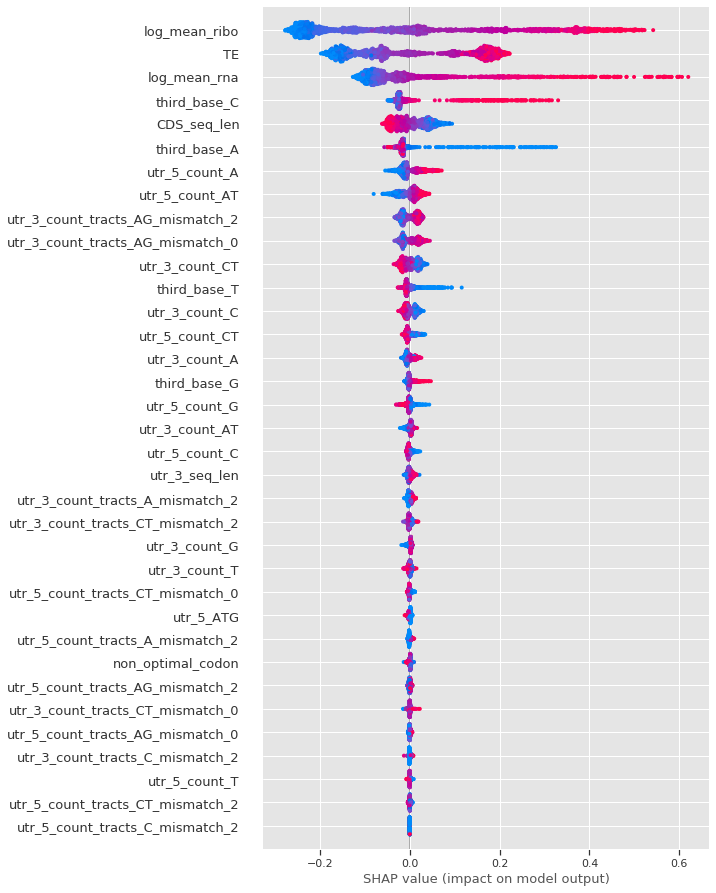

In [64]:
explainer = shap.TreeExplainer(regr)
shap_values = explainer.shap_values(X_test)

# Create the SHAP summary plot
shap.summary_plot(shap_values, 
                  X_test, 
                  feature_names=X_test.columns,
                  max_display=50, show=False, color_bar=False)

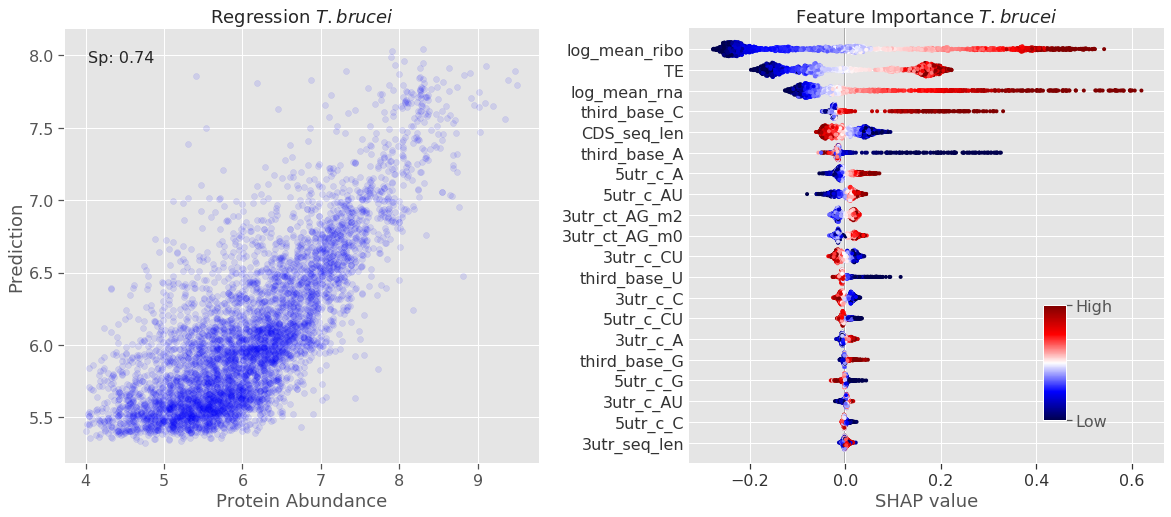

In [65]:
import matplotlib
fig = plt.figure(figsize=(16, 8))
# Increase right margin to accommodate colorbar
plt.subplots_adjust(left=0.1, right=0.85)  # Adjusted right margin

# Create gridspec without the colorbar position
gs = fig.add_gridspec(1, 2, width_ratios=[0.45, 0.45], wspace=0.4)
axes = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1])]
plt.rcParams.update({'font.size': 16})

# First plot (scatter plot)
axes[0].scatter(all_true_values, all_predictions, c='blue', alpha=0.1)
abline(all_true_values, all_predictions, axes[0], visualize = ['Sp'])
axes[0].set_ylabel('Prediction', fontsize=18)
axes[0].set_xlabel('Protein Abundance', fontsize=18)
axes[0].set_title('Regression $\it{T. brucei}$', fontsize=18)
axes[0].tick_params(axis='both', labelsize=16)

# Simple seismic colorbar first
my_cmap = plt.get_cmap('seismic')
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)

feature_names = [multiple_replace(n) for n in list(X_test.columns)]
# SHAP plot in the middle
plt.sca(axes[1])  
shap.summary_plot(shap_values, 
                 X_test, 
                 feature_names=feature_names,
                 max_display=20, show=False, plot_size=(16,8), color_bar=False)
axes[1].tick_params(axis='both', labelsize=16)  
axes[1].set_title('Feature Importance $\it{T. brucei}$', fontsize=18)
axes[1].set_xlabel('SHAP value', fontsize=18)

# Apply colormap
for fc in fig.get_children():
    for fcc in fc.get_children():
        if hasattr(fcc, "set_cmap"): 
            fcc.set_cmap(my_cmap)

# Adjust positions manually for main plots
pos0 = axes[0].get_position()
pos1 = axes[1].get_position()
axes[0].set_position([pos0.x0, pos0.y0, pos0.width+0.1, pos0.height])
axes[1].set_position([pos1.x0+0.105, pos1.y0, pos1.width+0.1, pos1.height])
axes[1].tick_params(axis='y', pad=-15)
# Add colorbar after adjusting main plots
cax = fig.add_axes([0.95, 0.2, 0.02, 0.2])  # [left, bottom, width, height]
cb = matplotlib.colorbar.ColorbarBase(cax, cmap=my_cmap, norm=norm)
cb.set_ticks([-1, 1])
cb.set_ticklabels(['Low', 'High'])
cb.ax.tick_params(labelsize=16)

#plt.savefig('Tb_TE.png', bbox_inches='tight', dpi=300)
#plt.savefig('Tb_TE.svg', bbox_inches='tight')
#plt.show()

In [66]:
feature_names.index('third_base_C')

28

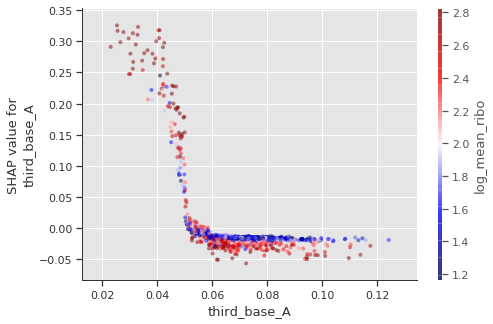

In [67]:
shap.dependence_plot('third_base_A', 
                     shap_values, 
                     X_test, show=False,
                     cmap='seismic',
                     #interaction_index=24,
                     feature_names=feature_names, alpha=0.5)
#plt.title('Interaction Values $\it{T. brucei}$',fontsize=18)
#plt.ylabel('SHAP 3UTR Length')
#plt.xlabel('3UTR Length')
#current_ticks = plt.xticks()[0]
#new_labels = [str(int(10**x)) for x in current_ticks]
#plt.xticks(current_ticks, new_labels)
new_labels[-1]=''
new_labels[0]=''
plt.show()

In [68]:
# show versions of packages
# adopted from https://stackoverflow.com/questions/40428931/package-for-listing-version-of-packages-used-in-a-jupyter-notebook
import pkg_resources
import types
import sys
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]
        elif isinstance(val, type):
            name = val.__module__.split(".")[0]
        # Some packages are weird and have different
        # imported names vs. system/pip names. Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name. You'll have to add
        # exceptions to this list manually!
        poorly_named_packages = {
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]
        yield name.lower()
imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
modules = []
for m in sys.builtin_module_names:
    if m.lower() in imports and m !='builtins':
        modules.append((m,'Python BuiltIn'))
        imports.remove(m.lower())

for m in pkg_resources.working_set:
    if m.project_name.lower() in imports and m.project_name!="pip":
        modules.append((m.project_name, m.version))
        imports.remove(m.project_name.lower())

for m in sys.modules:
    if m.lower() in imports and m !='builtins':
        modules.append((m,'unknown'))

# print('System=='+platform.system()+' '+platform.release()+'; Version=='+platform.version())
for r in modules:
    print("{}=={}".format(*r))

sys==Python BuiltIn
tqdm==4.36.1
shap==0.35.0
seaborn==0.9.0
scipy==1.3.2
scikit-learn==0.22
pandas==0.25.2
numpy==1.17.3
matplotlib==3.1.1
types==unknown
re==unknown
pkg_resources==unknown
concordance_index==unknown
repeated_analysis==unknown
cross_validate_random_forest==unknown
norm==unknown


In [69]:
#conda create -n ml_utr python=3.8 matplotlib=3.5.1 numpy=1.21.6 \
#scipy=1.10.1 pandas=1.4.2 scikit-learn=1.0.2 shap=0.39.0 \
#eli5=0.13.0 seaborn=0.11.2 jupyterlab numba=0.53
#conda activate ml_utr
#jupyter lab